Financial Modeling

1. Data Collection
2. Data Preprocessing
3. Feature Engineering
4. Simple Model Training
5. Simple Model Evaluation
6. Rolling Model Training
7. Rolling Model Backtesting
8. Prediction




In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt

df = pd.read_csv('unicorn.csv')

In [2]:
df = df.sort_values(by='unix', ascending=True)
df.reset_index(drop=True, inplace=True)  # optional, to re-label the rows

df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1526364000,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
1,1526367600,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
2,1526371200,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
3,1526374800,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
4,1526378400,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


In [3]:
# Drop the first 50,000 rows from the dataframe
df = df.iloc[50000:].reset_index(drop=True)

# Display the first few rows after dropping to verify
print(f"DataFrame now has {len(df)} rows")
df.head()


DataFrame now has 10307 rows


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1706364000,2024-01-27 14:00:00,BTC/USD,41734.0,41809.0,41725.0,41760.0,20.207973,8.438850e+05
1,1706367600,2024-01-27 15:00:00,BTC/USD,41766.0,41879.0,41735.0,41810.0,39.463768,1.649980e+06
2,1706371200,2024-01-27 16:00:00,BTC/USD,41809.0,41888.0,41795.0,41813.0,30.239874,1.264420e+06
3,1706374800,2024-01-27 17:00:00,BTC/USD,41805.0,41846.0,41774.0,41782.0,13.262858,5.541487e+05
4,1706378400,2024-01-27 18:00:00,BTC/USD,41782.0,41809.0,41749.0,41797.0,15.391466,6.433171e+05


In [4]:
# Price returns (close-to-close)
df['price_change_1h'] = df['close'].pct_change() * 100

df.head()

df['price_change_1h'].describe()

count    10306.000000
mean         0.008243
std          0.569235
min         -4.921150
25%         -0.229846
50%          0.010065
75%          0.256756
max          4.932016
Name: price_change_1h, dtype: float64

In [5]:
import numpy as np

def garman_klass_volatility(open_: pd.Series, high: pd.Series, 
                            low: pd.Series, close: pd.Series, 
                            window: int) -> pd.Series:
    """
    Compute the Garman-Klass volatility over a rolling window.
    """
    log_hl = np.log(high / low)
    log_co = np.log(close / open_)
    
    # Garman-Klass per-bar measure
    gk = 0.5 * (log_hl ** 2) - (2*np.log(2) - 1) * (log_co ** 2)
    
    # Rolling mean of gk, then sqrt
    rolling_mean = gk.rolling(window=window).mean()
    gk_vol = np.sqrt(rolling_mean)
    
    return gk_vol

# Example usage (rolling 12 hours on 1h data):
df['garman_klass_12h'] = garman_klass_volatility(
    df['open'], df['high'], df['low'], df['close'], window=12
)

In [6]:
df['price_range_pct'] = (df['high'] - df['low']) / df['close'] * 100
df['price_range_pct'].describe()

count    10307.000000
mean         0.742650
std          0.591266
min          0.000000
25%          0.379521
50%          0.572716
75%          0.912746
max          8.409450
Name: price_range_pct, dtype: float64

In [7]:
df['oc_change_pct'] = (df['close'] - df['open']) / df['open'] * 100
df['oc_change_pct'].describe()

count    10307.000000
mean         0.008437
std          0.568611
min         -4.925380
25%         -0.229013
50%          0.010085
75%          0.257179
max          4.933042
Name: oc_change_pct, dtype: float64

In [8]:
import numpy as np
def parkinson_volatility(high, low, window):
    log_hl_sq = np.log(high / low) ** 2
    rolling_sum = log_hl_sq.rolling(window=window).sum()
    factor = 1 / (4 * np.log(2) * window)
    return np.sqrt(factor * rolling_sum)

df['parkinson_3h'] = parkinson_volatility(df['high'], df['low'], window=3)

df.head(20)

df['parkinson_3h'].describe()

count    10305.000000
mean         0.004717
std          0.003204
min          0.000417
25%          0.002632
50%          0.003858
75%          0.005896
max          0.033361
Name: parkinson_3h, dtype: float64

In [9]:
df['ma_3h'] = df['close'].rolling(window=3).mean()

df.head(20)

df['ma_3h'].describe()

count     10305.000000
mean      73091.950024
std       16422.157768
min       41794.333333
25%       61774.666667
50%       67366.000000
75%       88519.666667
max      108002.333333
Name: ma_3h, dtype: float64

In [10]:
df['rolling_std_3h'] = df['close'].rolling(window=3).std()

df.head(20)

df['rolling_std_3h'].describe()

count    10305.000000
mean       244.629706
std        250.108243
min          0.000000
25%         93.664294
50%        168.964493
75%        301.737192
max       3356.193727
Name: rolling_std_3h, dtype: float64

In [11]:
# --- 1. Longer Lookback Periods ---

# a) Lagged Returns (using 'close' price)
# Calculate 1-hour pct change if not already done accurately
# Note: Your existing lag_N_price_return might be different, double-check its calculation.
# Here we calculate the simple 1-hour return ending at the current row.
df['price_return_1h'] = df['close'].pct_change() * 100 # Calculate % return

lag_periods_price = [3, 6, 12, 24, 48, 72, 168] # Hours (168h = 1 week)
for lag in lag_periods_price:
    # This creates the return from 'lag' hours ago up to 'lag-1' hours ago
    df[f'lag_{lag}h_price_return'] = df['price_return_1h'].shift(lag -1) # Shift the 1h return

# b) Lagged Volume Changes (Using Volume BTC for example)
# Calculate 1-hour pct change in volume
df['volume_return_1h'] = df['Volume BTC'].pct_change() * 100

lag_periods_volume = [3, 6, 12, 24]
for lag in lag_periods_volume:
     df[f'lag_{lag}h_volume_return'] = df['volume_return_1h'].shift(lag - 1)

# c) Longer Moving Averages (MA)
ma_periods = [6, 12, 24, 48, 72, 168] # Hours
for p in ma_periods:
    df[f'ma_{p}h'] = df['close'].rolling(window=p).mean()

# d) Longer Rolling Standard Deviation (Volatility of Returns)
std_periods = [6, 12, 24, 48, 72, 168] # Hours
for p in std_periods:
    # Use the 1-hour return we calculated earlier
    df[f'rolling_std_{p}h'] = df['price_return_1h'].rolling(window=p).std()

In [12]:
# --- 2. More Sophisticated Volatility Measures ---

# a) Average True Range (ATR)
# Calculate True Range (TR)
df['prev_close'] = df['close'].shift(1)
df['high_minus_low'] = df['high'] - df['low']
df['high_minus_prev_close'] = np.abs(df['high'] - df['prev_close'])
df['low_minus_prev_close'] = np.abs(df['low'] - df['prev_close'])
df['true_range'] = df[['high_minus_low', 'high_minus_prev_close', 'low_minus_prev_close']].max(axis=1)

# Calculate ATR (using simple moving average for simplicity here)
atr_periods = [14, 24, 48] # Common periods (often days, but using hours here)
for p in atr_periods:
     df[f'atr_{p}h'] = df['true_range'].rolling(window=p).mean()

# Clean up intermediate TR columns
df = df.drop(columns=['prev_close', 'high_minus_low', 'high_minus_prev_close', 'low_minus_prev_close', 'true_range'])

In [13]:
# --- 3. Trend Indicators / Interaction Features ---

# a) Price relative to longer MAs
for p in [24, 48, 168]: # Compare close to some key MAs
    if f'ma_{p}h' in df.columns:
        df[f'close_div_ma_{p}h'] = df['close'] / df[f'ma_{p}h']

# b) Short-term MA relative to longer MA (proxy for crossover/trend strength)
if 'ma_12h' in df.columns and 'ma_48h' in df.columns:
     df['ma12_div_ma48'] = df['ma_12h'] / df['ma_48h']
if 'ma_24h' in df.columns and 'ma_168h' in df.columns:
     df['ma24_div_ma168'] = df['ma_24h'] / df['ma_168h']

# c) Volatility Ratio (Short-term vs Long-term)
if 'rolling_std_12h' in df.columns and 'rolling_std_72h' in df.columns:
     # Add small epsilon to denominator to prevent division by zero if std dev is ever 0
     epsilon = 1e-9
     df['std12_div_std72'] = df['rolling_std_12h'] / (df['rolling_std_72h'] + epsilon)

# d) Volume * Price Range (Interaction) - Use existing price_range_pct
if 'price_range_pct' in df.columns:
    df['volume_btc_x_range'] = df['Volume BTC'] * df['price_range_pct']

In [14]:
# --- 4. Non-linear Transformations ---

# a) Powers (Square, Cube) - Apply to some existing/new features
# Be cautious: can create very large values or amplify noise. Apply selectively.
if 'rolling_std_3h' in df.columns:
    df['rolling_std_3h_sq'] = df['rolling_std_3h'] ** 2
if 'price_return_1h' in df.columns:
    df['price_return_1h_sq'] = df['price_return_1h'] ** 2
    # df['price_return_1h_cubed'] = df['price_return_1h'] ** 3 # Cube might be too much

# b) Square Root - Apply typically to non-negative features like volatility
if 'rolling_std_12h' in df.columns:
     # Add small epsilon before sqrt for numerical stability if std dev can be exactly 0
     epsilon = 1e-9
     df['rolling_std_12h_sqrt'] = np.sqrt(df['rolling_std_12h'] + epsilon)

In [15]:
print("Columns:", df.columns.tolist())
print("DataFrame shape after adding features:", df.shape)

Columns: ['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD', 'price_change_1h', 'garman_klass_12h', 'price_range_pct', 'oc_change_pct', 'parkinson_3h', 'ma_3h', 'rolling_std_3h', 'price_return_1h', 'lag_3h_price_return', 'lag_6h_price_return', 'lag_12h_price_return', 'lag_24h_price_return', 'lag_48h_price_return', 'lag_72h_price_return', 'lag_168h_price_return', 'volume_return_1h', 'lag_3h_volume_return', 'lag_6h_volume_return', 'lag_12h_volume_return', 'lag_24h_volume_return', 'ma_6h', 'ma_12h', 'ma_24h', 'ma_48h', 'ma_72h', 'ma_168h', 'rolling_std_6h', 'rolling_std_12h', 'rolling_std_24h', 'rolling_std_48h', 'rolling_std_72h', 'rolling_std_168h', 'atr_14h', 'atr_24h', 'atr_48h', 'close_div_ma_24h', 'close_div_ma_48h', 'close_div_ma_168h', 'ma12_div_ma48', 'ma24_div_ma168', 'std12_div_std72', 'volume_btc_x_range', 'rolling_std_3h_sq', 'price_return_1h_sq', 'rolling_std_12h_sqrt']
DataFrame shape after adding features: (10307, 54)


In [16]:
# --- IMPORTANT: Handle NaNs introduced by new features ---
print(f"\nNaN count before handling new NaNs:\n{df.isnull().sum().sort_values(ascending=False).head(20)}")
# You will need to drop rows with NaNs again before feeding to the model
# The number of rows dropped will depend on the longest lookback period used (e.g., 168 hours)
initial_rows = df.shape[0]
df = df.dropna()
final_rows = df.shape[0]
print(f"\nHandled NaNs from new features. Dropped {initial_rows - final_rows} rows.")
print(f"Final DataFrame shape after adding features and cleaning: {df.shape}")


NaN count before handling new NaNs:
lag_168h_price_return    168
rolling_std_168h         168
ma24_div_ma168           167
ma_168h                  167
close_div_ma_168h        167
lag_72h_price_return      72
rolling_std_72h           72
std12_div_std72           72
ma_72h                    71
lag_48h_price_return      48
rolling_std_48h           48
close_div_ma_48h          47
atr_48h                   47
ma12_div_ma48             47
ma_48h                    47
lag_24h_volume_return     25
rolling_std_24h           24
lag_24h_price_return      24
close_div_ma_24h          23
atr_24h                   23
dtype: int64

Handled NaNs from new features. Dropped 173 rows.
Final DataFrame shape after adding features and cleaning: (10134, 54)


In [17]:
# --- Handle Infinite Values ---
# Get numeric columns only
numeric_cols = df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
print("\nChecking numeric columns for infinite values:", numeric_cols.tolist())

# Check for infinite values in numeric columns only
inf_count = np.isinf(df[numeric_cols]).sum().sum()
print(f"\nNumber of infinite values before handling: {inf_count}")

if inf_count > 0:
    # Replace infinite values with NaN in numeric columns only
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
    
    # Drop rows with NaN values (which now include the former infinite values)
    rows_before = df.shape[0]
    df = df.dropna()
    rows_after = df.shape[0]
    
    print(f"Replaced infinite values with NaN and dropped them.")
    print(f"Rows removed due to infinite values: {rows_before - rows_after}")
else:
    print("No infinite values found in the numeric columns of the dataframe.")

print(f"Final DataFrame shape after handling infinite values: {df.shape}")


Checking numeric columns for infinite values: ['unix', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD', 'price_change_1h', 'garman_klass_12h', 'price_range_pct', 'oc_change_pct', 'parkinson_3h', 'ma_3h', 'rolling_std_3h', 'price_return_1h', 'lag_3h_price_return', 'lag_6h_price_return', 'lag_12h_price_return', 'lag_24h_price_return', 'lag_48h_price_return', 'lag_72h_price_return', 'lag_168h_price_return', 'volume_return_1h', 'lag_3h_volume_return', 'lag_6h_volume_return', 'lag_12h_volume_return', 'lag_24h_volume_return', 'ma_6h', 'ma_12h', 'ma_24h', 'ma_48h', 'ma_72h', 'ma_168h', 'rolling_std_6h', 'rolling_std_12h', 'rolling_std_24h', 'rolling_std_48h', 'rolling_std_72h', 'rolling_std_168h', 'atr_14h', 'atr_24h', 'atr_48h', 'close_div_ma_24h', 'close_div_ma_48h', 'close_div_ma_168h', 'ma12_div_ma48', 'ma24_div_ma168', 'std12_div_std72', 'volume_btc_x_range', 'rolling_std_3h_sq', 'price_return_1h_sq', 'rolling_std_12h_sqrt']

Number of infinite values before handling: 10
Repl

In [18]:
# --- Prepare Data for Modeling ---
print("\n--- Preparing Data for Modeling ---")

# 1. Drop non-numeric columns (date, symbol) that can't be used for modeling
# First, identify string columns
string_cols = df.select_dtypes(include=['object']).columns
print(f"String columns to drop: {string_cols.tolist()}")

# Drop string columns and unix timestamp
df_model = df.drop(columns=string_cols)
# Drop unix timestamp column as it's not a feature
# We're predicting price_change_1h which is the price change for the next hour
df_model = df_model.drop(columns=['unix'])
print(f"Dropped 'unix' timestamp column")

# Drop price_return_1h column if it exists
if 'price_return_1h' in df_model.columns:
    df_model = df_model.drop(columns=['price_return_1h'])
    print(f"Dropped 'price_return_1h' column")

# 2. Set the target variable
target_col = 'price_change_1h'
print(f"\nTarget variable: {target_col}")

# 3. Separate features and target
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# 4. Check for any remaining issues
print(f"\nFeature columns: {X.columns.tolist()}")
print(f"Number of samples: {len(X)}")

# 5. Summary statistics of the target variable
print("\nTarget variable statistics:")
print(y.describe())



--- Preparing Data for Modeling ---
String columns to drop: ['date', 'symbol']
Dropped 'unix' timestamp column
Dropped 'price_return_1h' column

Target variable: price_change_1h

Feature matrix shape: (10124, 49)
Target vector shape: (10124,)

Feature columns: ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD', 'garman_klass_12h', 'price_range_pct', 'oc_change_pct', 'parkinson_3h', 'ma_3h', 'rolling_std_3h', 'lag_3h_price_return', 'lag_6h_price_return', 'lag_12h_price_return', 'lag_24h_price_return', 'lag_48h_price_return', 'lag_72h_price_return', 'lag_168h_price_return', 'volume_return_1h', 'lag_3h_volume_return', 'lag_6h_volume_return', 'lag_12h_volume_return', 'lag_24h_volume_return', 'ma_6h', 'ma_12h', 'ma_24h', 'ma_48h', 'ma_72h', 'ma_168h', 'rolling_std_6h', 'rolling_std_12h', 'rolling_std_24h', 'rolling_std_48h', 'rolling_std_72h', 'rolling_std_168h', 'atr_14h', 'atr_24h', 'atr_48h', 'close_div_ma_24h', 'close_div_ma_48h', 'close_div_ma_168h', 'ma12_div_ma48', 'ma24_di

In [19]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# First, let's create binary classification labels
# 1 for price increase, 0 for decrease or no change
threshold = 0  # You can adjust this threshold
y_binary = (y > threshold).astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, 
    test_size=0.2,
    shuffle=False  # Important for time series data
)

# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.01,
    n_estimators=1000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=1  # Adjust if classes are imbalanced
)

# Train the model
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric=['auc', 'error'],
    early_stopping_rounds=50,
    verbose=100
)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print metrics
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Feature importance
importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'feature': features, 'importance': importance})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

[0]	validation_0-auc:0.99560	validation_0-error:0.01333	validation_1-auc:0.99421	validation_1-error:0.02519


C:\Users\mason\AppData\Roaming\Python\Python312\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\mason\AppData\Roaming\Python\Python312\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-auc:0.99958	validation_0-error:0.00803	validation_1-auc:0.99851	validation_1-error:0.01580

Model Performance Metrics:
Accuracy: 0.9857
Precision: 0.9872
Recall: 0.9843
F1 Score: 0.9857

Top 10 Most Important Features:
                 feature  importance
8          oc_change_pct    0.766777
39      close_div_ma_24h    0.013722
47    price_return_1h_sq    0.012259
19      volume_return_1h    0.010764
42         ma12_div_ma48    0.010447
40      close_div_ma_48h    0.009650
31       rolling_std_12h    0.006678
26                ma_24h    0.006382
30        rolling_std_6h    0.006223
48  rolling_std_12h_sqrt    0.005821


In [20]:
# Get the last data point from the test set to predict the next hour
last_data_point = X_test.iloc[-1:].copy()

# Make prediction for the next hour
next_hour_prediction = model.predict(last_data_point)[0]
next_hour_probability = model.predict_proba(last_data_point)[0, 1]

# Interpret the prediction
if next_hour_prediction == 1:
    prediction_text = "INCREASE (>0%)"
else:
    prediction_text = "DECREASE (≤0%)"

print("\nPrediction for Next Hour:")
print(f"The model predicts the price will {prediction_text}")
print(f"Confidence: {max(next_hour_probability, 1-next_hour_probability):.4f}")

# Create a function to make predictions on new data
def predict_next_hour(new_data_point, model):
    """
    Make prediction for the next hour using the trained model
    
    Parameters:
    -----------
    new_data_point : pandas DataFrame
        A single row DataFrame with the same features as the training data
    model : XGBClassifier
        The trained XGBoost model
        
    Returns:
    --------
    prediction : int
        0 for decrease, 1 for increase
    probability : float
        Probability of the predicted class
    """
    prediction = model.predict(new_data_point)[0]
    probability = model.predict_proba(new_data_point)[0, 1]
    
    return prediction, probability

# Example of how to use the function with the most recent data
# (This would be updated with new data in a production environment)
prediction, probability = predict_next_hour(last_data_point, model)
print(f"\nUsing the prediction function: {'INCREASE' if prediction == 1 else 'DECREASE'} with {max(probability, 1-probability):.4f} confidence")



Prediction for Next Hour:
The model predicts the price will INCREASE (>0%)
Confidence: 0.5341

Using the prediction function: INCREASE with 0.5341 confidence


In [21]:
# Calculate 12-hour future returns
df['price_change_12h'] = df['close'].shift(-12).sub(df['close']).div(df['close']).mul(100)

# --- Prepare Data for Modeling ---
print("\n--- Preparing Data for Modeling ---")

# 1. Drop non-numeric columns and unnecessary columns
string_cols = df.select_dtypes(include=['object']).columns
df_model = df.drop(columns=string_cols)
df_model = df_model.drop(columns=['unix'])

# 2. Set the target variable for 12h prediction
target_col = 'price_change_12h'
print(f"\nTarget variable: {target_col}")

# 3. Remove rows with NaN in target (caused by the shift operation)
df_model = df_model.dropna(subset=[target_col])

# 4. Separate features and target
# Keep price_return_1h and oc_change_pct as they may be valuable predictors for 12h changes
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Create binary classification labels for 12h prediction
threshold = 0  # You can adjust this threshold
y_binary = (y > threshold).astype(int)

# Split the data - use a larger test set for longer-term predictions
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, 
    test_size=0.2,
    shuffle=False  # Important for time series data
)

# Initialize XGBoost classifier with slightly modified parameters
model_12h = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.01,
    n_estimators=1000,
    min_child_weight=2,  # Increased to reduce overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=1
)

# Train the model
model_12h.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric=['auc', 'error'],
    early_stopping_rounds=50,
    verbose=100
)

# Make predictions
y_pred = model_12h.predict(X_test)
y_pred_proba = model_12h.predict_proba(X_test)[:, 1]

# Print metrics
print("\nModel Performance Metrics (12-hour predictions):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Feature importance
importance = model_12h.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'feature': features, 'importance': importance})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for 12h Prediction:")
print(importance_df.head(10))

# Predict next 12 hours
last_data_point = X_test.iloc[-1:].copy()
next_12h_prediction = model_12h.predict(last_data_point)[0]
next_12h_probability = model_12h.predict_proba(last_data_point)[0, 1]

print("\nPrediction for Next 12 Hours:")
prediction_text = "INCREASE (>0%)" if next_12h_prediction == 1 else "DECREASE (≤0%)"
print(f"The model predicts the price will {prediction_text}")
print(f"Confidence: {max(next_12h_probability, 1-next_12h_probability):.4f}")

# Function to make 12-hour predictions
def predict_next_12h(new_data_point, model):
    """
    Make prediction for the next 12 hours using the trained model
    
    Parameters:
    -----------
    new_data_point : pandas DataFrame
        A single row DataFrame with the same features as the training data
    model : XGBClassifier
        The trained XGBoost model
        
    Returns:
    --------
    prediction : int
        0 for decrease, 1 for increase
    probability : float
        Probability of the predicted class
    """
    prediction = model.predict(new_data_point)[0]
    probability = model.predict_proba(new_data_point)[0, 1]
    
    return prediction, probability


--- Preparing Data for Modeling ---

Target variable: price_change_12h

Feature matrix shape: (10112, 51)
Target vector shape: (10112,)
[0]	validation_0-auc:0.68404	validation_0-error:0.37582	validation_1-auc:0.50392	validation_1-error:0.47306


C:\Users\mason\AppData\Roaming\Python\Python312\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\mason\AppData\Roaming\Python\Python312\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[87]	validation_0-auc:0.91403	validation_0-error:0.17307	validation_1-auc:0.56257	validation_1-error:0.45774

Model Performance Metrics (12-hour predictions):
Accuracy: 0.5606
Precision: 0.5369
Recall: 0.6345
F1 Score: 0.5816

Top 10 Most Important Features for 12h Prediction:
                 feature  importance
29                ma_48h    0.037337
11                 ma_3h    0.036335
1                   high    0.034508
37      rolling_std_168h    0.033320
31               ma_168h    0.032988
28                ma_24h    0.032972
45        ma24_div_ma168    0.032115
35       rolling_std_48h    0.032055
50  rolling_std_12h_sqrt    0.031441
36       rolling_std_72h    0.030927

Prediction for Next 12 Hours:
The model predicts the price will DECREASE (≤0%)
Confidence: 0.5014


In [22]:
# Import XGBClassifier from xgboost
from xgboost import XGBClassifier

# Implement rolling backtesting for 12h prediction
print("\nPerforming Rolling Backtesting for 12h Prediction Model:")

# Define parameters for rolling backtesting
initial_train_size = 72  # Initial training window size
step_size = 4  # Move forward by 5 hours each iteration
test_size = 12  # Test on the next 12 hours

# Prepare data for backtesting
backtest_data = df.dropna().copy()  # Ensure we have clean data
backtest_features = X.columns  # Use the same features as our main model

# Initialize lists to store results
all_predictions = []
all_actual = []
all_probabilities = []
all_timestamps = []

# Loop through the data with rolling windows
for i in range(initial_train_size, len(backtest_data) - test_size, step_size):
    # Define train and test sets for this iteration
    train_data = backtest_data.iloc[:i]
    test_point = backtest_data.iloc[i:i+1]  # Test on the next point
    
    # Get the timestamp for this prediction
    test_timestamp = test_point['date'].values[0]
    
    # Prepare X and y for training
    X_train_roll = train_data[backtest_features]
    y_train_roll = (train_data['price_change_12h'] > 0).astype(int)
    
    # Prepare test point
    X_test_roll = test_point[backtest_features]
    y_test_roll = (test_point['price_change_12h'] > 0).astype(int)
    
    # Train a model on this window
    model_roll = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42
    )
    
    # Fit the model
    model_roll.fit(X_train_roll, y_train_roll)
    
    # Make prediction
    pred_roll = model_roll.predict(X_test_roll)[0]
    prob_roll = model_roll.predict_proba(X_test_roll)[0, 1]
    
    # Store results
    all_predictions.append(pred_roll)
    all_actual.append(y_test_roll.values[0])
    all_probabilities.append(prob_roll)
    all_timestamps.append(test_timestamp)
    
    # Print progress every 50 iterations
    if (i - initial_train_size) % (step_size * 50) == 0:
        print(f"Processed {i - initial_train_size} windows...")

# Convert results to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)
all_probabilities = np.array(all_probabilities)

# Calculate performance metrics
accuracy = accuracy_score(all_actual, all_predictions)
precision = precision_score(all_actual, all_predictions)
recall = recall_score(all_actual, all_predictions)
f1 = f1_score(all_actual, all_predictions)

# Create a DataFrame with results
backtest_results = pd.DataFrame({
    'timestamp': all_timestamps,
    'actual': all_actual,
    'predicted': all_predictions,
    'probability': all_probabilities
})

# Print performance metrics
print("\nBacktesting Results:")
print(f"Number of test points: {len(all_predictions)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate profit/loss assuming equal bet size
backtest_results['correct'] = backtest_results['actual'] == backtest_results['predicted']
win_rate = backtest_results['correct'].mean()
print(f"Win Rate: {win_rate:.4f}")



Performing Rolling Backtesting for 12h Prediction Model:
Processed 0 windows...
Processed 200 windows...
Processed 400 windows...
Processed 600 windows...
Processed 800 windows...
Processed 1000 windows...
Processed 1200 windows...
Processed 1400 windows...
Processed 1600 windows...
Processed 1800 windows...
Processed 2000 windows...
Processed 2200 windows...
Processed 2400 windows...
Processed 2600 windows...
Processed 2800 windows...
Processed 3000 windows...
Processed 3200 windows...
Processed 3400 windows...
Processed 3600 windows...
Processed 3800 windows...
Processed 4000 windows...
Processed 4200 windows...
Processed 4400 windows...
Processed 4600 windows...
Processed 4800 windows...
Processed 5000 windows...
Processed 5200 windows...
Processed 5400 windows...
Processed 5600 windows...
Processed 5800 windows...
Processed 6000 windows...
Processed 6200 windows...
Processed 6400 windows...
Processed 6600 windows...
Processed 6800 windows...
Processed 7000 windows...
Processed 720

[0]	validation_0-auc:0.61355	validation_1-auc:0.53037
[1]	validation_0-auc:0.63605	validation_1-auc:0.53925
[2]	validation_0-auc:0.64056	validation_1-auc:0.53589
[3]	validation_0-auc:0.65874	validation_1-auc:0.53932
[4]	validation_0-auc:0.66759	validation_1-auc:0.53903
[5]	validation_0-auc:0.67115	validation_1-auc:0.54170
[6]	validation_0-auc:0.67911	validation_1-auc:0.54332
[7]	validation_0-auc:0.67960	validation_1-auc:0.54301
[8]	validation_0-auc:0.68828	validation_1-auc:0.54269
[9]	validation_0-auc:0.69395	validation_1-auc:0.54409
[10]	validation_0-auc:0.70135	validation_1-auc:0.54508
[11]	validation_0-auc:0.70188	validation_1-auc:0.54442
[12]	validation_0-auc:0.70265	validation_1-auc:0.54441
[13]	validation_0-auc:0.70481	validation_1-auc:0.54467
[14]	validation_0-auc:0.70457	validation_1-auc:0.54378
[15]	validation_0-auc:0.70903	validation_1-auc:0.54286
[16]	validation_0-auc:0.71344	validation_1-auc:0.54209
[17]	validation_0-auc:0.71623	validation_1-auc:0.53790
[18]	validation_0-au

C:\Users\mason\AppData\Roaming\Python\Python312\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\mason\AppData\Roaming\Python\Python312\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


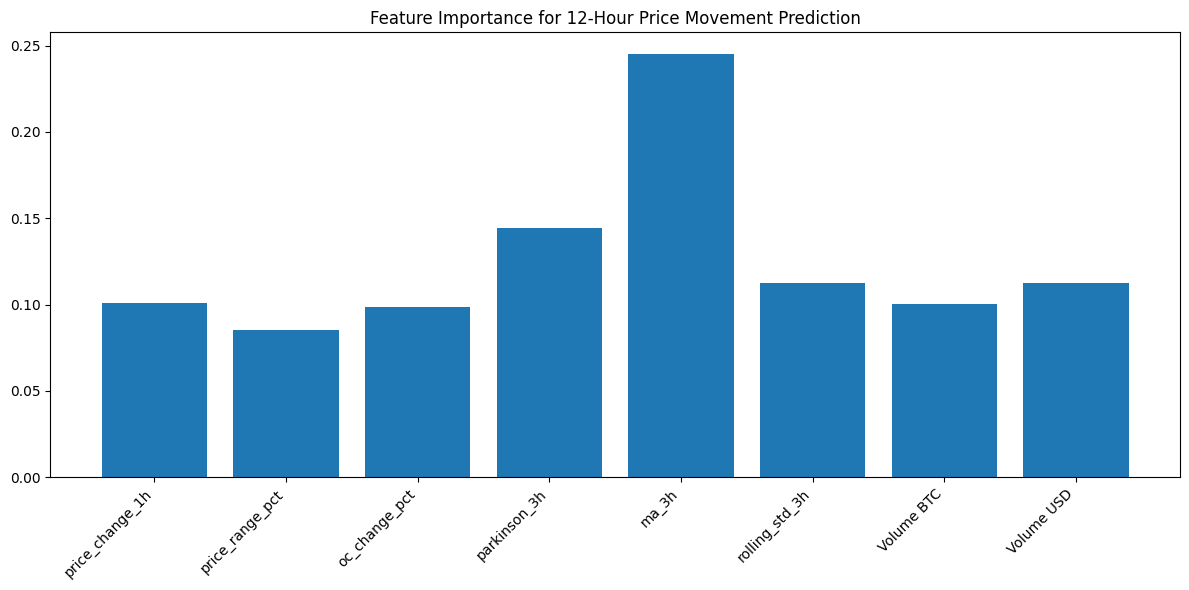

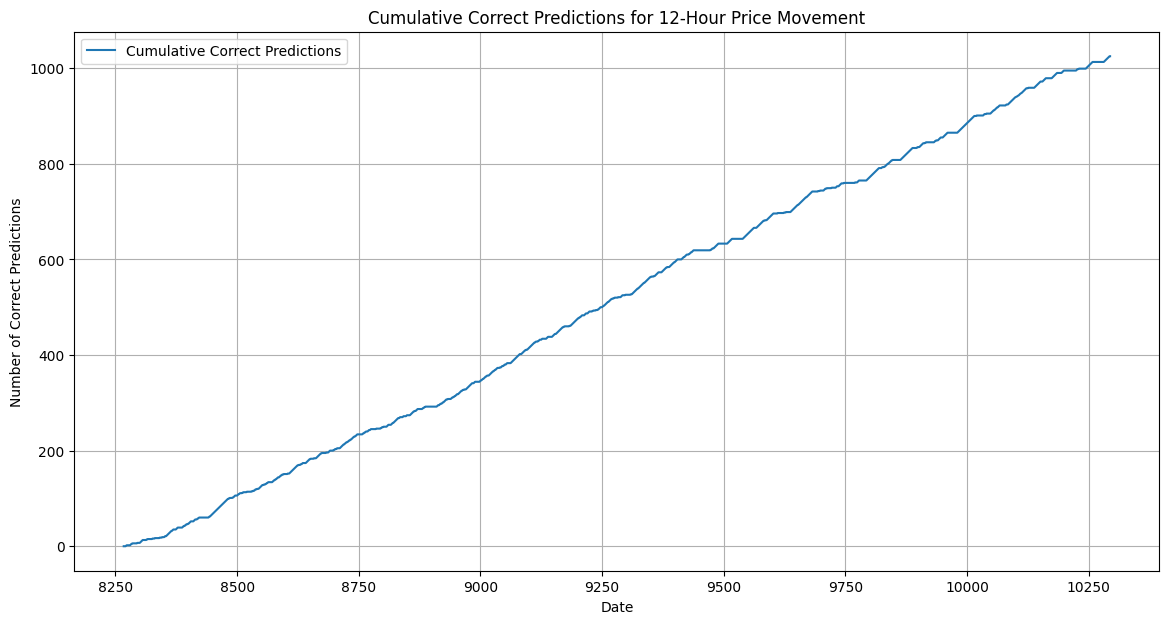

In [29]:
# Import necessary libraries if not already imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Create a target variable for 12-hour price movement (up or down)
df['price_change_12h'] = df['close'].shift(-12).sub(df['close']).div(df['close']).mul(100)
df['target_12h'] = (df['price_change_12h'] > 0).astype(int)

# Drop rows with NaN values (due to the shift operation)
df_clean = df.dropna()

# Define features for the model
features = [
    'price_change_1h', 'price_range_pct', 'oc_change_pct', 
    'parkinson_3h', 'ma_3h', 'rolling_std_3h',
    'Volume BTC', 'Volume USD'
]

# Split the data into features and target
X = df_clean[features]
y = df_clean['target_12h']

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # Time series data, so no shuffling
)

# Initialize the XGBoost classifier
xgb_model_12h = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42
)

# Train the model
xgb_model_12h.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='auc',
    early_stopping_rounds=10,
    verbose=True
)

# Make predictions on the test set
y_pred = xgb_model_12h.predict(X_test)
y_prob = xgb_model_12h.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\n12-Hour Price Movement Prediction Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(xgb_model_12h.feature_importances_)), xgb_model_12h.feature_importances_)
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.title('Feature Importance for 12-Hour Price Movement Prediction')
plt.tight_layout()
plt.show()

# Create a DataFrame with test results
test_results = pd.DataFrame({
    'timestamp': X_test.index,
    'actual': y_test,
    'predicted': y_pred,
    'probability': y_prob,
    'correct': y_test == y_pred
})

# Plot cumulative correct predictions
plt.figure(figsize=(14, 7))
plt.plot(test_results.index, test_results['correct'].cumsum(), label='Cumulative Correct Predictions')
plt.title('Cumulative Correct Predictions for 12-Hour Price Movement')
plt.xlabel('Date')
plt.ylabel('Number of Correct Predictions')
plt.legend()
plt.grid(True)
plt.show()


--- Starting Initial Model Training ---
Training initial model on first 100 samples (100 rounds)...
Initial training finished in 0.03 seconds.

--- Starting Incremental Rolling Window Validation ---
Initial train size: 100, Horizon: 12, Step: 5, Incremental rounds: 10
Total iterations: 2001
  Iteration 1/2001: No new data in slice [100:100]. Skipping training update.
  Iteration 50/2001 complete. Trained on new data [340:345], Predicted on [345:357]
  Iteration 100/2001 complete. Trained on new data [590:595], Predicted on [595:607]
  Iteration 150/2001 complete. Trained on new data [840:845], Predicted on [845:857]
  Iteration 200/2001 complete. Trained on new data [1090:1095], Predicted on [1095:1107]
  Iteration 250/2001 complete. Trained on new data [1340:1345], Predicted on [1345:1357]
  Iteration 300/2001 complete. Trained on new data [1590:1595], Predicted on [1595:1607]
  Iteration 350/2001 complete. Trained on new data [1840:1845], Predicted on [1845:1857]
  Iteration 400/2001

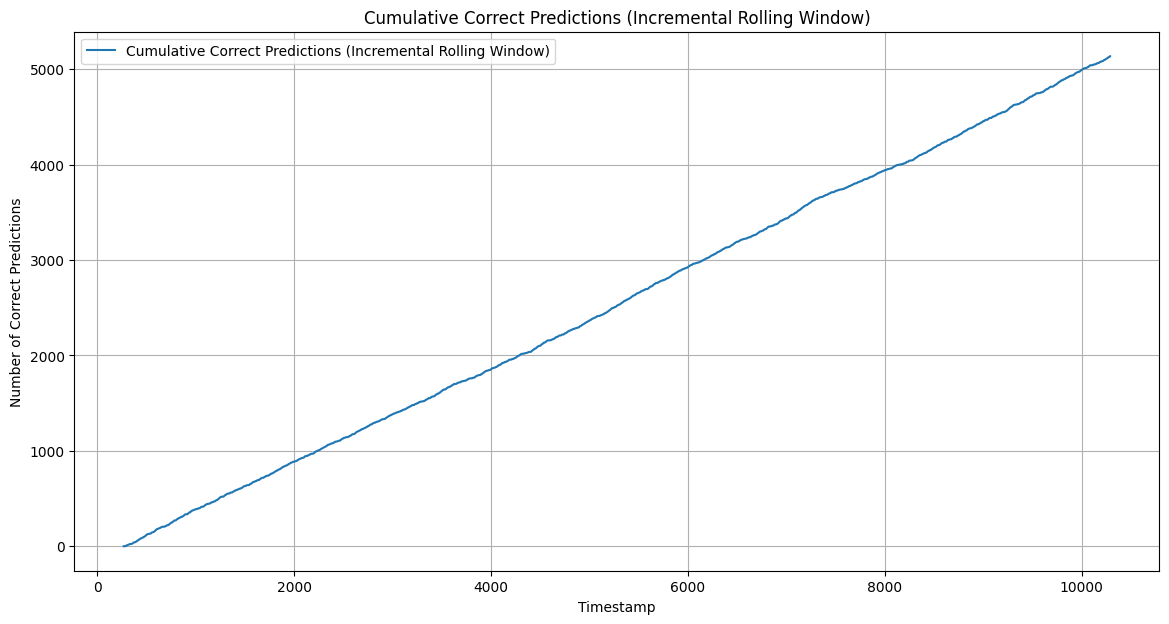

<Figure size 1200x800 with 0 Axes>

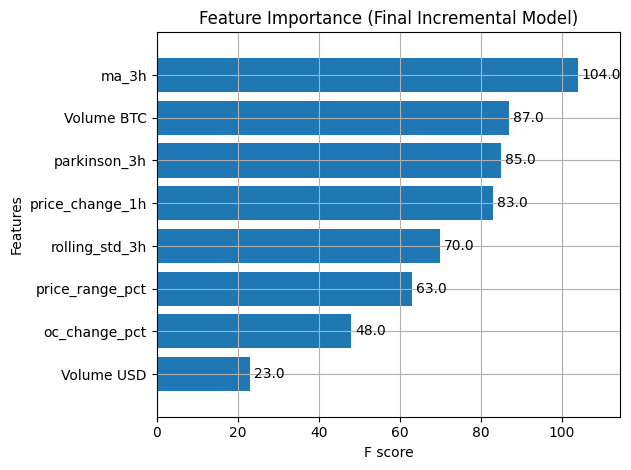

In [30]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb # Use core xgboost library
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import warnings

# Suppress specific XGBoost warnings if desired (optional)
# warnings.filterwarnings("ignore", message="Saving data in binary format") # Example

# --- Data Preparation (Assuming df is already loaded and features engineered) ---
# Create target variable for 12-hour price movement
df['price_change_12h'] = df['close'].shift(-12).sub(df['close']).div(df['close']).mul(100)
df['target_12h'] = (df['price_change_12h'] > 0).astype(int)

# Define features (ensure these columns exist in df)
features = [
    'price_change_1h', 'price_range_pct', 'oc_change_pct',
    'parkinson_3h', 'ma_3h', 'rolling_std_3h',
    'Volume BTC', 'Volume USD'
    # Add any other relevant engineered features used previously
]

# Drop rows with NaN values (crucial after shift and feature engineering)
# Ensure all columns needed (features + target) are considered for dropping NaNs
all_needed_cols = ['price_change_12h', 'target_12h'] + features
df_clean = df.dropna(subset=all_needed_cols).copy()

# Ensure only selected features exist after cleaning
available_features = [f for f in features if f in df_clean.columns]
if len(available_features) != len(features):
    print("Warning: Some specified features are not available in the cleaned DataFrame.")
    print("Using features:", available_features)
features = available_features # Update features list to only available ones

X = df_clean[features]
y = df_clean['target_12h']
n_samples = len(X)

# --- Rolling Window & Model Parameters ---
initial_train_size = 100 # Size of the first training set
prediction_horizon = 12  # Predict next 12 hours
step = 5                 # Slide window forward by 5 hours each time
incremental_rounds = 10 # Number of *additional* boosting rounds per step

# XGBoost parameters (using a dictionary for the core API)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # Area Under Curve
    'eta': 0.1,           # Learning rate
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'seed': 42
    # Add other parameters like gamma, lambda, alpha if needed for regularization
}

# --- Initial Model Training ---
print("--- Starting Initial Model Training ---")
if n_samples < initial_train_size + prediction_horizon:
     raise ValueError("Not enough data for initial training and first prediction.")

# Initial training data
X_train_init = X.iloc[0:initial_train_size]
y_train_init = y.iloc[0:initial_train_size]

# Convert initial data to DMatrix (XGBoost's internal data structure)
dtrain_init = xgb.DMatrix(X_train_init, label=y_train_init, feature_names=features)

# Train the first model
initial_boost_rounds = 100 # Number of rounds for the very first training
print(f"Training initial model on first {initial_train_size} samples ({initial_boost_rounds} rounds)...")
start_time_init = time.time()
current_model = xgb.train(
    params,
    dtrain_init,
    num_boost_round=initial_boost_rounds,
    # evals=[(dtrain_init, 'train')], # Optional: evaluate on initial train data
    verbose_eval=False # Suppress verbose output during training loops
)
end_time_init = time.time()
print(f"Initial training finished in {end_time_init - start_time_init:.2f} seconds.")


# --- Incremental Rolling Window Training and Prediction ---
all_test_indices = []
all_predictions = []
all_probabilities = []
all_actuals = []

print("\n--- Starting Incremental Rolling Window Validation ---")
print(f"Initial train size: {initial_train_size}, Horizon: {prediction_horizon}, Step: {step}, Incremental rounds: {incremental_rounds}")
start_time_rolling = time.time()

# Calculate the number of iterations
# Loop starts after the initial training window, ends when prediction horizon goes past data
loop_start_index = initial_train_size
loop_end_index = n_samples - prediction_horizon
num_iterations = (loop_end_index - loop_start_index) // step + 1
print(f"Total iterations: {num_iterations}")

current_iteration = 0
last_train_end_idx = initial_train_size

for i in range(loop_start_index, loop_end_index, step):
    current_iteration += 1

    # Define indices for the *new* data slice to train on
    train_start_idx_new = last_train_end_idx
    train_end_idx_new = i # The current position marks the end of the new training data

    # Define indices for the test set (next prediction_horizon steps)
    test_start_idx = train_end_idx_new
    test_end_idx = test_start_idx + prediction_horizon

    # Extract the *new* training data slice
    X_train_new_slice = X.iloc[train_start_idx_new:train_end_idx_new]
    y_train_new_slice = y.iloc[train_start_idx_new:train_end_idx_new]

    # Extract test data
    X_test_roll = X.iloc[test_start_idx:test_end_idx]
    y_test_roll = y.iloc[test_start_idx:test_end_idx]

    # Store the actual indices from the original DataFrame for the test set
    test_indices = X_test_roll.index

    if X_train_new_slice.empty:
        print(f"  Iteration {current_iteration}/{num_iterations}: No new data in slice [{train_start_idx_new}:{train_end_idx_new}]. Skipping training update.")
    else:
        # Convert *only the new slice* to DMatrix
        dtrain_new = xgb.DMatrix(X_train_new_slice, label=y_train_new_slice, feature_names=features)

        # --- Incremental Training Step ---
        # Continue training the *existing* model with the new data
        current_model = xgb.train(
            params,
            dtrain_new,
            num_boost_round=incremental_rounds, # Add specified number of rounds
            xgb_model=current_model, # Pass the existing model to continue training!
            verbose_eval=False
        )

    # --- Prediction Step ---
    # Convert test data to DMatrix
    dtest = xgb.DMatrix(X_test_roll, feature_names=features)
    # Make predictions using the *updated* model
    y_prob_roll = current_model.predict(dtest)
    y_pred_roll = (y_prob_roll > 0.5).astype(int) # Convert probabilities to binary prediction

    # Store results
    all_test_indices.extend(test_indices.tolist())
    all_predictions.extend(y_pred_roll.tolist())
    all_probabilities.extend(y_prob_roll.tolist())
    all_actuals.extend(y_test_roll.tolist())

    # Update the end index for the next iteration's new slice calculation
    last_train_end_idx = train_end_idx_new

    if current_iteration % 50 == 0 or current_iteration == num_iterations: # Print progress periodically
         print(f"  Iteration {current_iteration}/{num_iterations} complete. Trained on new data [{train_start_idx_new}:{train_end_idx_new}], Predicted on [{test_start_idx}:{test_end_idx}]")


end_time_rolling = time.time()
print(f"Incremental rolling window validation finished in {end_time_rolling - start_time_rolling:.2f} seconds.")

# --- Evaluate Overall Performance ---
if all_actuals: # Check if any predictions were made
    # Remove duplicates if windows overlap in test predictions (less likely with step=horizon, but good practice)
    results_df = pd.DataFrame({
        'actual': all_actuals,
        'predicted': all_predictions,
        'probability': all_probabilities
    }, index=pd.Index(all_test_indices, name='timestamp'))
    results_df = results_df[~results_df.index.duplicated(keep='last')] # Keep prediction from latest model for overlaps
    results_df = results_df.sort_index()

    # Recalculate metrics on potentially de-duplicated results
    final_actuals = results_df['actual']
    final_predictions = results_df['predicted']

    accuracy = accuracy_score(final_actuals, final_predictions)
    precision = precision_score(final_actuals, final_predictions, zero_division=0)
    recall = recall_score(final_actuals, final_predictions, zero_division=0)
    f1 = f1_score(final_actuals, final_predictions, zero_division=0)
    conf_matrix = confusion_matrix(final_actuals, final_predictions)

    print("\nOverall Incremental Rolling Window Performance (12-Hour Prediction):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # --- Plotting Results ---
    results_df['correct'] = results_df['actual'] == results_df['predicted']

    plt.figure(figsize=(14, 7))
    plt.plot(results_df.index, results_df['correct'].cumsum(), label='Cumulative Correct Predictions (Incremental Rolling Window)')
    plt.title('Cumulative Correct Predictions (Incremental Rolling Window)')
    plt.xlabel('Timestamp')
    plt.ylabel('Number of Correct Predictions')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot feature importance from the *final* incrementally trained model
    plt.figure(figsize=(12, 8)) # Increased size for potentially many features
    xgb.plot_importance(current_model, height=0.8, max_num_features=20) # Plot top 20 features
    plt.title('Feature Importance (Final Incremental Model)')
    plt.tight_layout()
    plt.show()

else:
    print("No predictions were made. Check window/step parameters and data length.")


Running backtest with the existing model...

Backtest Results (Direction Prediction):
Accuracy: 0.5190
Precision: 0.5029
Recall: 0.5730
F1 Score: 0.5356
ROC AUC: 0.5276
Win Rate: 0.5190


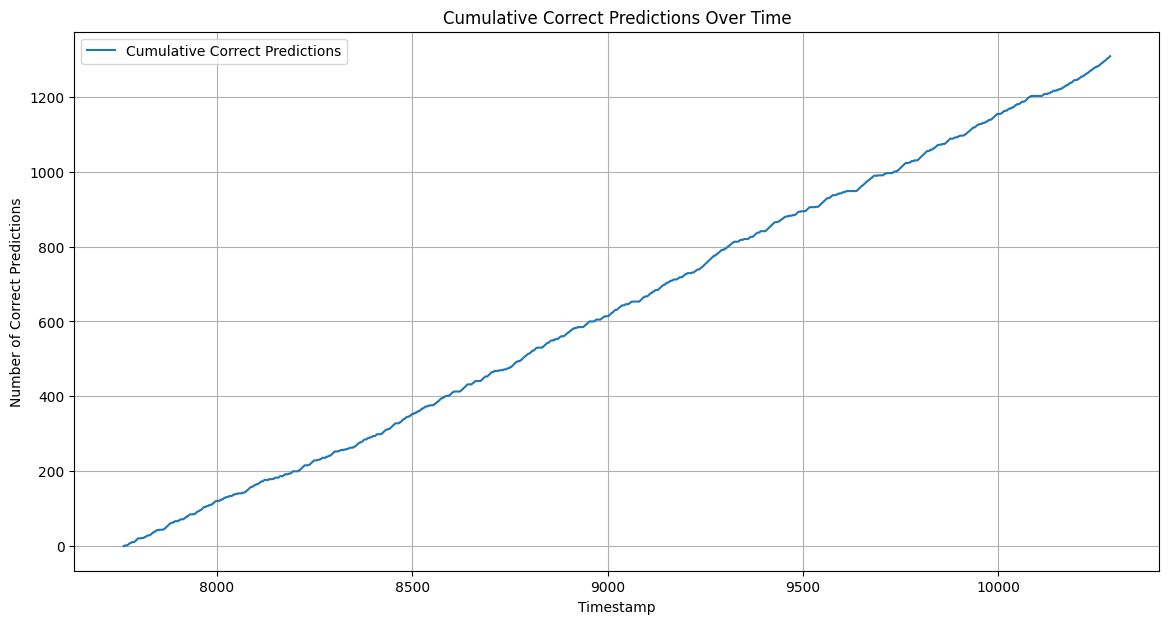

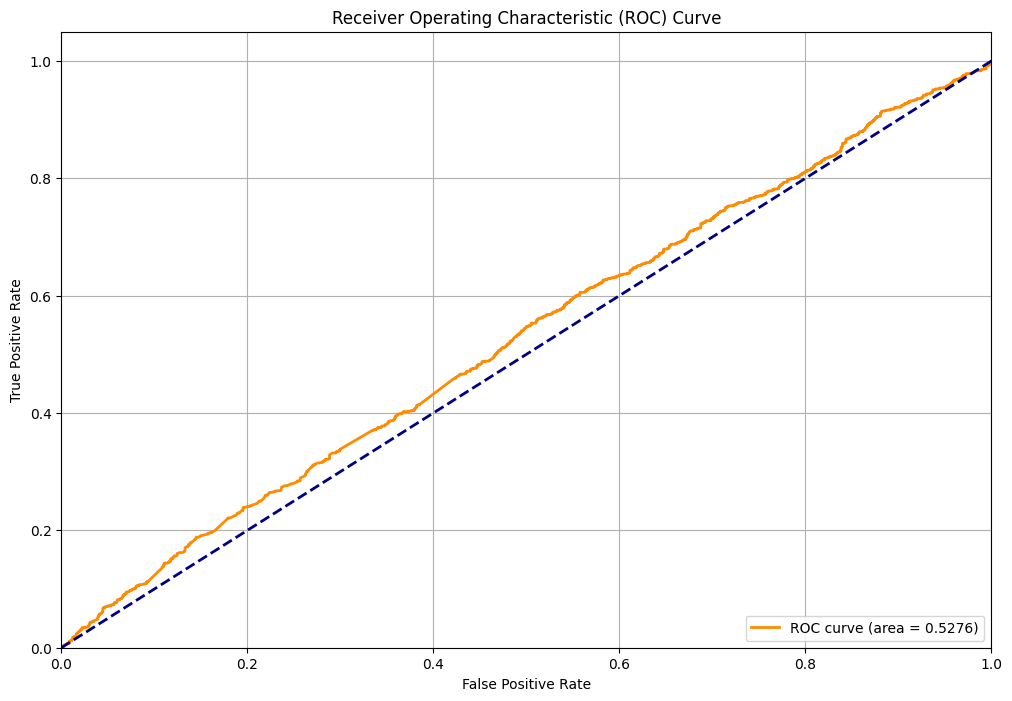

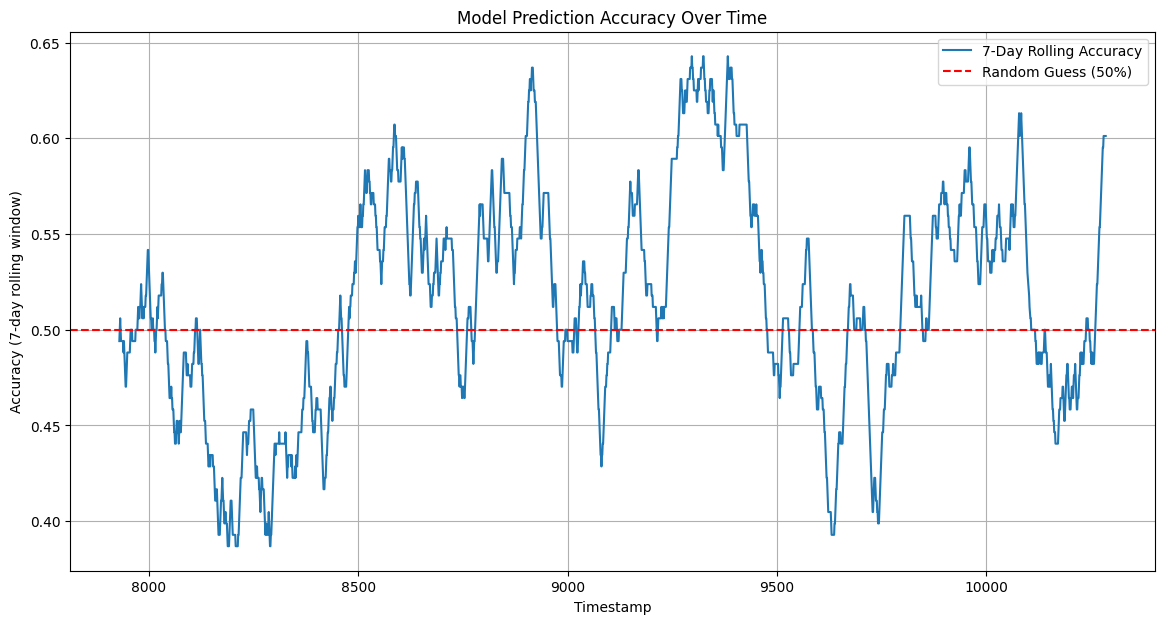

In [35]:
# Backtest the already trained model and create an ROC AUC curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def backtest_existing_model(model, df, features, target_col, window_size=168, step_size=24):
    """
    Backtest the already trained XGBoost model using rolling windows.
    
    Parameters:
    -----------
    model : XGBoost model
        The already trained model to evaluate
    df : pandas DataFrame
        The dataframe containing features and target
    features : list
        List of feature column names
    target_col : str
        Name of the target column
    window_size : int
        Size of the test window for each evaluation
    step_size : int
        Number of steps to move forward for each iteration
    
    Returns:
    --------
    pandas DataFrame
        Results of the backtest including actual values, predictions, and probabilities
    """
    results = []
    
    # Ensure data is sorted by time
    df = df.sort_index()
    
    # Get the total number of samples
    n_samples = len(df)
    
    # Define the start indices for each window
    # We'll use the last 25% of data for backtesting to avoid using data the model was trained on
    start_idx = int(n_samples * 0.75)
    end_idx = n_samples
    
    # Define the test windows
    test_starts = range(start_idx, end_idx - window_size + 1, step_size)
    
    for test_start in test_starts:
        test_end = test_start + window_size
        
        # Skip if we don't have enough data
        if test_end > n_samples:
            continue
        
        # Get test data
        test_data = df.iloc[test_start:test_end]
        
        # Skip if target column has NaN values in test set
        if test_data[target_col].isna().any():
            continue
        
        # Prepare test data
        X_test = test_data[features]
        y_test = test_data[target_col]
        
        # Create DMatrix for prediction
        dtest = xgb.DMatrix(X_test, feature_names=features)
        
        # Make predictions
        y_prob = model.predict(dtest)
        y_pred = (y_prob >= 0.5).astype(int)
        
        # Store results
        for i in range(len(test_data)):
            results.append({
                'timestamp': test_data.index[i],
                'actual': y_test.iloc[i],
                'predicted': y_pred[i],
                'probability': y_prob[i],
                'correct': y_test.iloc[i] == y_pred[i]
            })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index('timestamp', inplace=True)
    
    # Remove duplicates (keep the latest prediction for each timestamp)
    results_df = results_df[~results_df.index.duplicated(keep='last')]
    results_df = results_df.sort_index()
    
    return results_df

# Run the backtest using the already trained model
print("Running backtest with the existing model...")
backtest_results = backtest_existing_model(
    current_model,  # Use the already trained model
    df_clean, 
    features, 
    'target_12h',  # Fixed target column name to match what's in the dataframe
    window_size=168,  # 7 days (assuming hourly data)
    step_size=24     # 1 day
)

# Calculate metrics
accuracy = accuracy_score(backtest_results['actual'], backtest_results['predicted'])
precision = precision_score(backtest_results['actual'], backtest_results['predicted'], zero_division=0)
recall = recall_score(backtest_results['actual'], backtest_results['predicted'], zero_division=0)
f1 = f1_score(backtest_results['actual'], backtest_results['predicted'], zero_division=0)
conf_matrix = confusion_matrix(backtest_results['actual'], backtest_results['predicted'])
roc_auc = roc_auc_score(backtest_results['actual'], backtest_results['probability'])

# Calculate win rate (percentage of correct predictions)
win_rate = backtest_results['correct'].mean()

print("\nBacktest Results (Direction Prediction):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Win Rate: {win_rate:.4f}")

# Plot the results over time
plt.figure(figsize=(14, 7))
plt.plot(backtest_results.index, backtest_results['correct'].cumsum(), label='Cumulative Correct Predictions')
plt.title('Cumulative Correct Predictions Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Correct Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Create ROC curve
fpr, tpr, thresholds = roc_curve(backtest_results['actual'], backtest_results['probability'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot prediction accuracy over time
plt.figure(figsize=(14, 7))
# Calculate rolling accuracy (7-day window)
rolling_window = 168  # 7 days assuming hourly data
backtest_results['rolling_accuracy'] = backtest_results['correct'].rolling(rolling_window).mean()
plt.plot(backtest_results.index, backtest_results['rolling_accuracy'], label=f'{rolling_window//24}-Day Rolling Accuracy')
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess (50%)')
plt.title('Model Prediction Accuracy Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Accuracy (7-day rolling window)')
plt.legend()
plt.grid(True)
plt.show()


Making prediction based on data from index: 10294

--- 12-Hour Price Prediction (Incremental Model) ---
Current BTC price (at 10294): $82772.00
Predicted direction for next 12h: UP
Confidence score: 0.7617 (76.17%)
Raw probability (Class 1): 0.7617
Prediction generated at: 2025-04-01 17:21:34


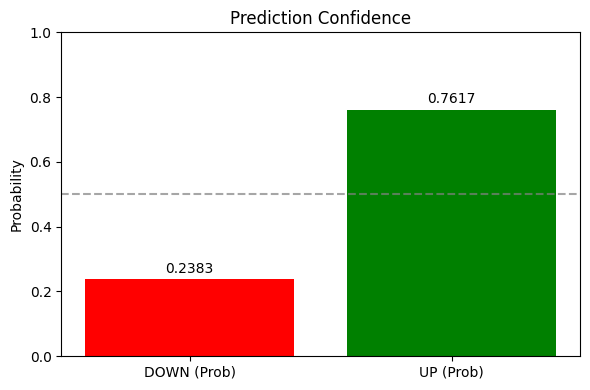

In [32]:
# Import datetime if not already imported
from datetime import datetime

# Get the latest data point from the *cleaned* dataframe used for training/testing
# Ensure it contains all necessary features BEFORE potential NaNs were introduced by future shifts
latest_data_point = df_clean.iloc[-1:]
print(f"Making prediction based on data from index: {latest_data_point.index[0]}")

# --- Prepare data for prediction using the core API ---
# 1. Get feature names directly from the Booster object
#    Make sure the 'features' list used during training is available here
required_features = current_model.feature_names
if required_features is None:
     # If feature_names weren't stored during DMatrix creation, use the list we defined
     required_features = features
     print("Warning: Feature names not found in Booster, using defined list.")

# 2. Select the required features from the latest data point
latest_features_df = latest_data_point[required_features]

# 3. Convert the latest data point to DMatrix for prediction
dlatest = xgb.DMatrix(latest_features_df, feature_names=required_features)

# --- Make Prediction ---
# Predict probability of the positive class (class 1)
probability_class1 = current_model.predict(dlatest)[0]

# Determine predicted class based on threshold (usually 0.5)
threshold = 0.5
prediction = 1 if probability_class1 >= threshold else 0

# Calculate confidence (probability of the predicted class)
confidence = probability_class1 if prediction == 1 else 1 - probability_class1

# --- Output Results ---
direction = "UP" if prediction == 1 else "DOWN"
# Get the 'close' price from the same latest data point
current_price = latest_data_point['close'].values[0]

print(f"\n--- 12-Hour Price Prediction (Incremental Model) ---")
print(f"Current BTC price (at {latest_data_point.index[0]}): ${current_price:.2f}")
print(f"Predicted direction for next 12h: {direction}")
print(f"Confidence score: {confidence:.4f} ({confidence*100:.2f}%)")
print(f"Raw probability (Class 1): {probability_class1:.4f}")
print(f"Prediction generated at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Visualize the confidence
plt.figure(figsize=(6, 4))
colors = ['red', 'green']
labels = ['DOWN (Prob)', 'UP (Prob)']
probabilities_viz = [1 - probability_class1, probability_class1] # Prob for Down, Prob for Up
plt.bar(labels, probabilities_viz, color=colors)
plt.title('Prediction Confidence')
plt.ylabel('Probability')
plt.ylim(0, 1)
for i, v in enumerate(probabilities_viz):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The model was correct! BTC moved up significantly in the next 12 hours.

The model prediction over timeplt indicates that the model is currently predicting accurately

Next Steps:
1. Add more features
2. Try different model parameters
3. Try different model types
4. Try different feature engineering techniques
5. Try different prediction horizons
6. Try different timeframes

Advanced Progression:
1. Use API to get real-time data
2. Feed new data to database
3. Continue to iterate on the model with new data
4. Set up alerts for when the model is predicting a certain direction when the model is winning
